## Import Required Packages for this Example

In [1]:
import gsw
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import xarray as xr

from acspype.utils.ooi import download_and_load_goldcopy, reformat_ooi_optaa, get_ooi_optaa_cal
import acspype.processing as acsproc
import acspype.qaqc as acsqaqc
from acspype.tscor import ACSTSCor

In [2]:
acs_url = 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/ooigoldcopy/public/CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered/deployment0013_CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered_20190624T165543.774000-20190627T023924.583000.nc'
acs = download_and_load_goldcopy(thredds_fileserver_url=acs_url,
                                 save_dir = 'ooi_data/')

In [3]:
acs = reformat_ooi_optaa(ds = acs)
acs = acs.sel(latitude = float(acs.latitude), longitude = float(acs.longitude), deployment = int(acs.deployment))

In [4]:
acs_dev = get_ooi_optaa_cal(ds = acs) # The get_ooi_optaa_cal function uses the uid in the dataset attributes.

In [5]:
acs['internal_temperature'] = acsproc.compute_internal_temperature(counts = acs.raw_internal_temperature)

In [6]:
acs['sea_water_absolute_salinity'] = gsw.SA_from_SP(acs.sea_water_practical_salinity, acs.sea_water_pressure, acs.longitude, acs.latitude)
acs['sea_water_conservative_temperature'] = gsw.CT_from_t(acs.sea_water_absolute_salinity, acs.sea_water_temperature, acs.sea_water_pressure)

In [7]:
acs['a_uncorrected'] = acsproc.compute_uncorrected(signal_counts=acs.a_signal, 
                                                   reference_counts = acs.a_reference, 
                                                   path_length=acs_dev.path_length)

acs['c_uncorrected'] = acsproc.compute_uncorrected(signal_counts=acs.c_signal, 
                                                   reference_counts=acs.c_reference, 
                                                   path_length =acs_dev.path_length)

C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [8]:
acs['a_m_discontinuity'] = acsproc.compute_measured(acs.a_uncorrected, acs.internal_temperature, acs_dev.a_offset, acs_dev.func_a_delta_t)
acs['c_m_discontinuity'] = acsproc.compute_measured(acs.c_uncorrected, acs.internal_temperature, acs_dev.c_offset, acs_dev.func_c_delta_t)

In [9]:
discontinuity_index = acsproc.find_discontinuity_index(a_wavelength = acs.a_wavelength, 
                                                       c_wavelength = acs.c_wavelength)
acs['a_m'], acs['a_discontinuity_offset'] = acsproc.discontinuity_correction(measured = acs.a_m_discontinuity,
                                                                             discontinuity_index=discontinuity_index,
                                                                             wavelength_dim='a_wavelength')
acs['c_m'], acs['c_discontinuity_offset'] = acsproc.discontinuity_correction(measured = acs.c_m_discontinuity,
                                                                             discontinuity_index=discontinuity_index,
                                                                             wavelength_dim='c_wavelength')

In [19]:
offset_top = acs.where(acs.depth < 5, drop = True)[['a_discontinuity_offset', 'c_discontinuity_offset']]
offset_bot = acs.where(acs.depth > 65, drop = True)[['a_discontinuity_offset', 'c_discontinuity_offset']]

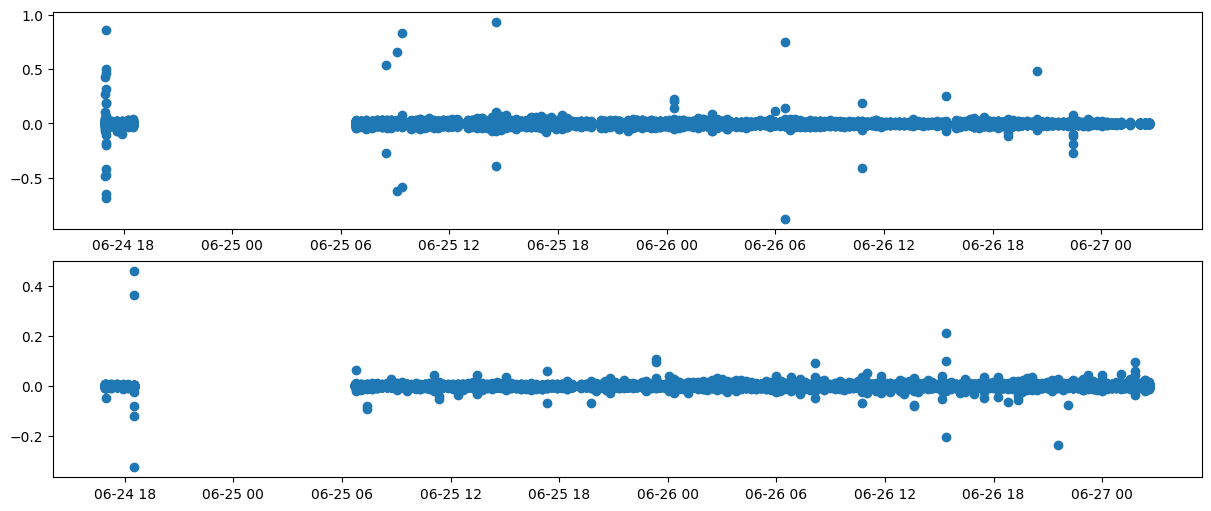

In [17]:
fig, ax = plt.subplots(2,1, figsize = (12,5), constrained_layout=True)

ax[0].plot(offset_top.time, offset_top.a_discontinuity_offset, 'o', color = 'C0', label = 'A Discontinuity Offset Top')


ax[1].plot(offset_bot.time, offset_bot.a_discontinuity_offset, 'o', color = 'C0', label = 'A Discontinuity Offset Bottom')